In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from utils import get_file_paths, load_dfs_by_source
from lstm import Vanilla_LSTM
from lgbm import LgbmModel, MultiModel
# from evaluation import calc_metrics, plot_metrics
from lgbm_data_prep import train_val_test_split_original, LgbmDataPrep

2024-02-06 15:18:46.325328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
x,v,t = train_val_test_split_original()

In [4]:
DATA_PATH = '/Users/orenben/Documents/runi/mlops-anomaly-detection/data/'
DATA_SOURCES = ['valve1','valve2','other']


In [5]:
data_dict_by_source = {source:load_dfs_by_source(DATA_PATH,source) for source in DATA_SOURCES}

In [6]:
valve1_df = data_dict_by_source['valve1']

In [7]:
model = LgbmModel()

In [8]:
t

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 15:02:21,0.027773,0.039028,1.326890,0.054711,68.5600,24.5135,231.830,32.9709,0.0,0.0
2020-03-09 15:02:22,0.027711,0.039946,1.110150,0.054711,68.5861,24.5136,239.315,32.0000,0.0,0.0
2020-03-09 15:02:23,0.027657,0.040355,1.273900,0.710565,68.4256,24.5084,240.306,32.0300,0.0,0.0
2020-03-09 15:02:24,0.027274,0.039846,0.819551,0.054711,68.6263,24.5139,236.042,32.9709,0.0,0.0
2020-03-09 15:02:25,0.027238,0.039922,1.101930,0.054711,68.4726,24.5196,236.624,32.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-09 15:34:37,0.027605,0.039760,0.622996,0.382638,68.4247,24.4370,230.358,32.9673,0.0,0.0
2020-03-09 15:34:38,0.027286,0.039613,0.600692,0.054711,68.0598,24.4356,231.373,32.0000,0.0,0.0
2020-03-09 15:34:39,0.027203,0.041440,0.450323,0.054711,68.1836,24.4379,210.605,32.0337,0.0,0.0


In [9]:
model.train(train_set=x)

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811


In [10]:
len(model.predict(t))

1844

<Axes: >

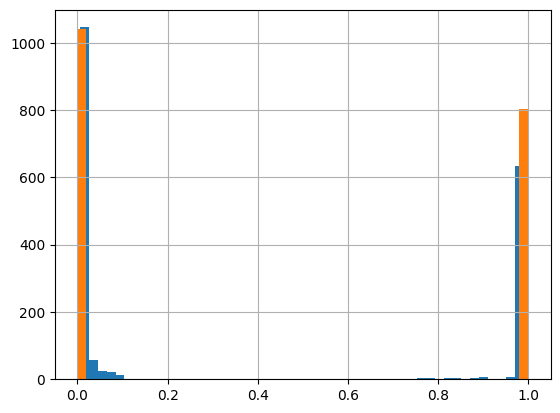

In [11]:
pd.Series(model.predict(t)).hist(bins=50)
pd.Series(model.y_test).hist(bins=50)

In [70]:
def calc_metrics(y_true,y_pred):
    th = 0.35
    accuracy = accuracy_score(y_true, np.where(y_pred>=th,1,0))
    cm = confusion_matrix(y_true, np.where(y_pred>=th,1,0))
    f1 = f1_score(y_true, np.where(y_pred>=th,1,0))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return accuracy,cm,f1,fpr, tpr, thresholds, roc_auc

In [71]:
accuracy,cm,f1,fpr, tpr, thresholds, roc_auc = calc_metrics(model.y_test,model.y_pred)

In [72]:
def plot_metrics(cm, fpr, tpr, roc_auc, thresholds, title = 'Model Evaluation Metrics'):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    fig.suptitle(title, fontsize=16, y=1.02)
    confusion_matrix_ax = ax[0]
    roc_curve_ax = ax[1]

    # Confusion Matrix in the first subplot
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=confusion_matrix_ax,cmap='Blues')
    confusion_matrix_ax.set_title('Confusion Matrix')
    confusion_matrix_ax.set_xlabel('Predicted labels')
    confusion_matrix_ax.set_ylabel('True labels')

    # ROC Curve in the second subplot
    roc_curve_ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    roc_curve_ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    roc_curve_ax.set_xlabel('False Positive Rate')
    roc_curve_ax.set_ylabel('True Positive Rate')
    roc_curve_ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    roc_curve_ax.legend(loc='lower right')

    # Annotate some key thresholds on the curve
    # Select thresholds to annotate on the ROC curve
    indices_to_annotate = [0, len(thresholds) // 3, 2 * len(thresholds) // 3, -1]
    # for i in indices_to_annotate:
    #     roc_curve_ax.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(10,-5), ha='center')

    # Display the plot
    plt.tight_layout()
    plt.show()

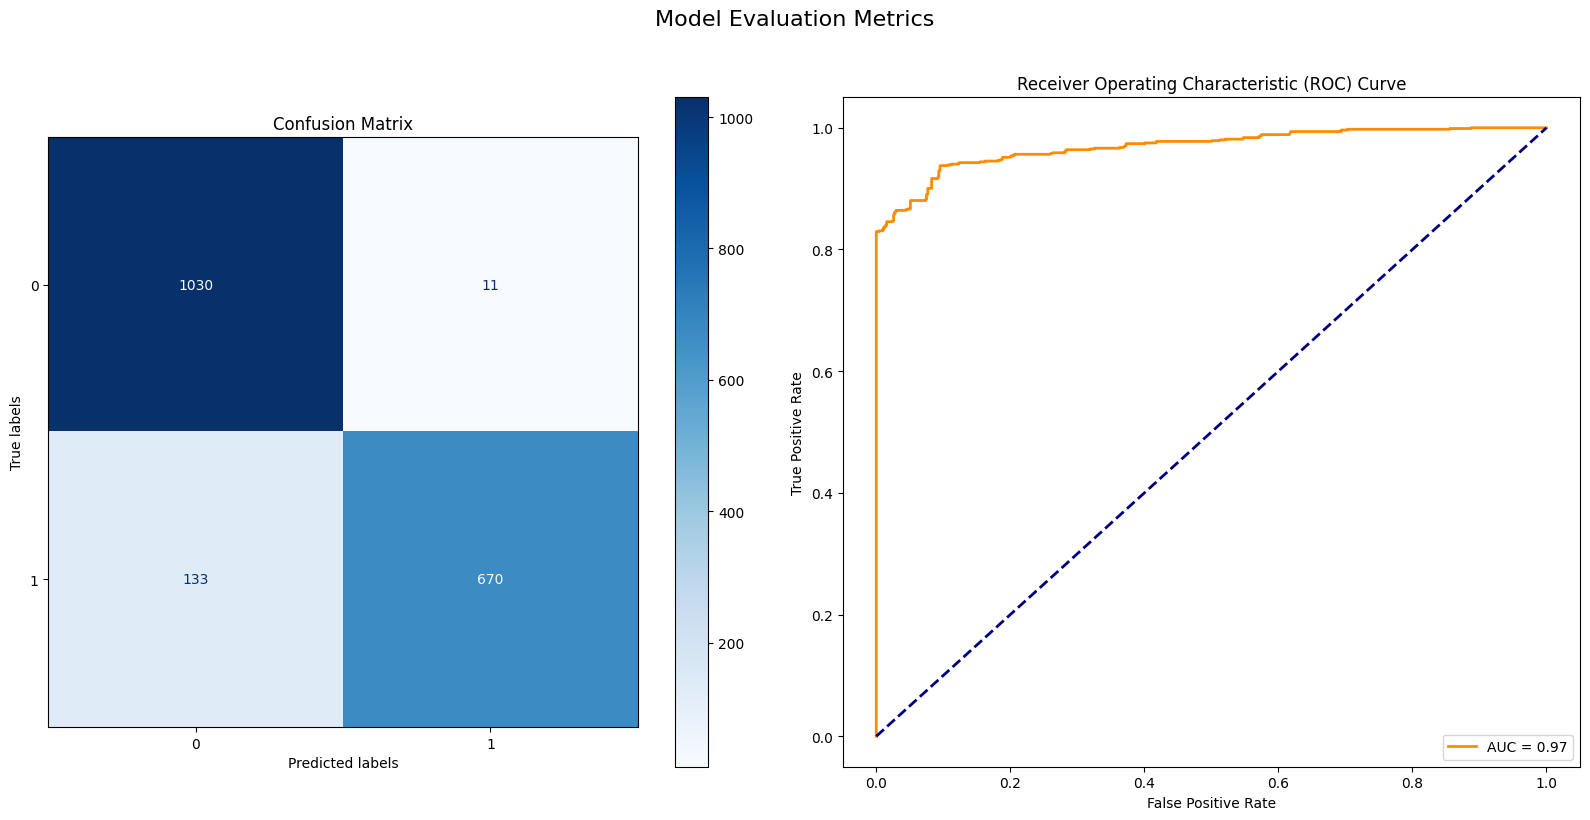

In [73]:
plot_metrics(cm,fpr, tpr,roc_auc,thresholds)

### try to train multimodel:

In [53]:
num_models = 5

In [54]:
mm = MultiModel()

In [55]:
mm.train(x)

[LightGBM] [Info] Number of positive: 803, number of negative: 1730
[LightGBM] [Info] Total Bins 6118
[LightGBM] [Info] Number of data points in the train set: 2533, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.317015 -> initscore=-0.767522
[LightGBM] [Info] Start training from score -0.767522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 741, number of negative: 1792
[LightGBM] [Info] Total Bins 6116
[LightGBM] [Info] Number of data points in the train set: 2533, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292538 -> initscore=-0.883087
[LightGBM] [Info] Start training from score -0.883087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [56]:
preds = mm.predict(t)

In [57]:
y_test = mm.y_test
avg_labels = preds['avg_predicion']

In [58]:
# thresholds

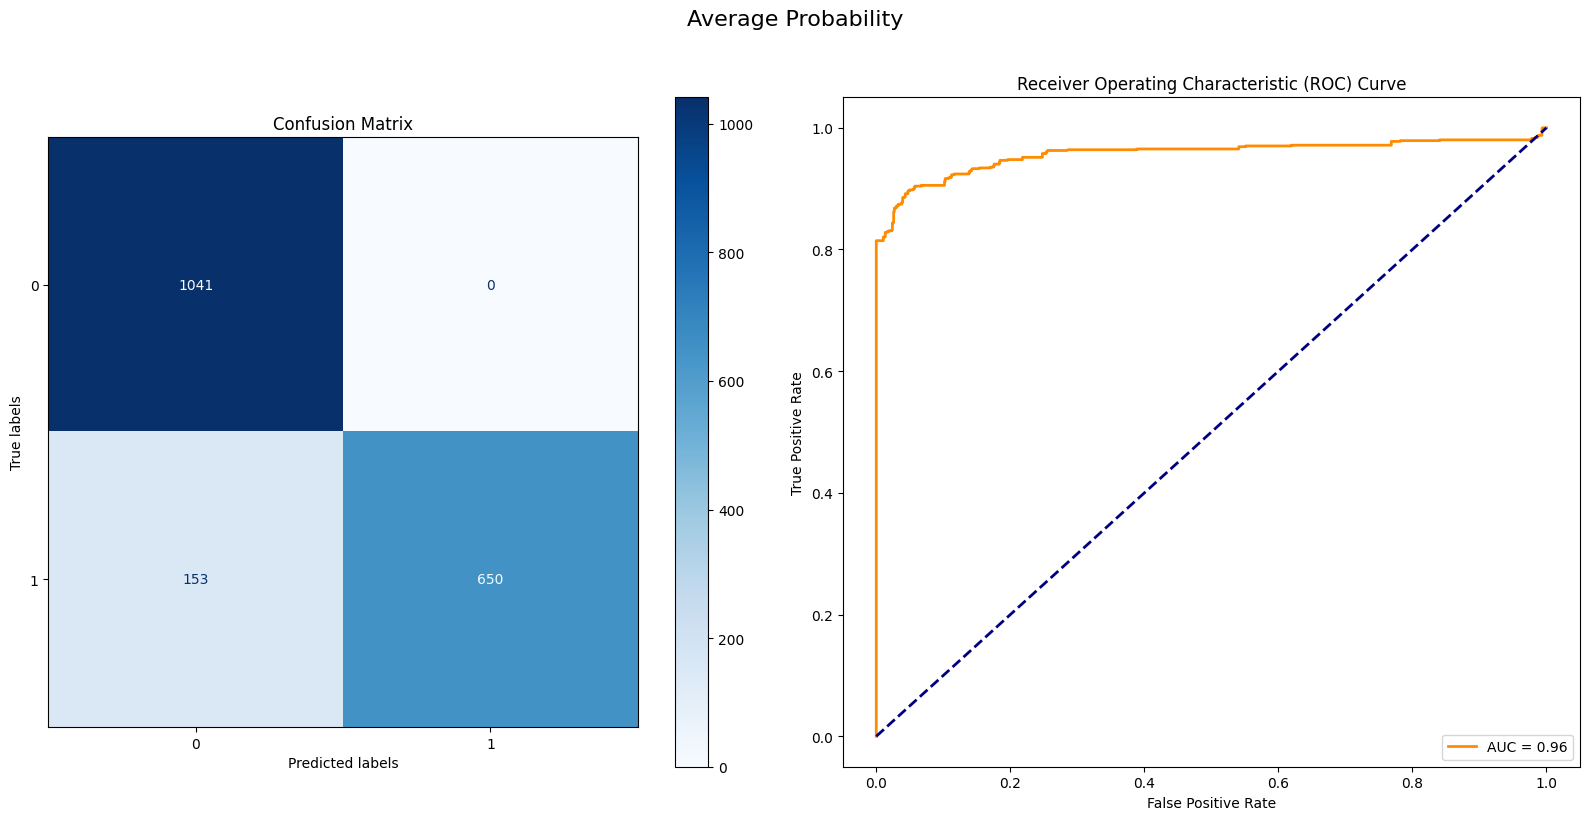

In [59]:

# avg_labels, avg_probabilities
accuracy, cm, f1, fpr, tpr, thresholds, roc_auc = calc_metrics(y_test,avg_labels)
plot_metrics(cm, fpr, tpr, roc_auc, thresholds, title = 'Average Probability')
# accuracy, f1, thresholds

In [60]:
path = '/Users/orenben/Documents/runi/mlops-anomaly-detection/data/lgbm_baseline_predictions.csv'
orig_preds = pd.read_csv(path)

In [61]:
orig_preds['y_pred']

0       0.009131
1       0.008209
2       0.007595
3       0.007595
4       0.007595
          ...   
1839    0.010491
1840    0.011267
1841    0.012052
1842    0.012052
1843    0.012052
Name: y_pred, Length: 1844, dtype: float64

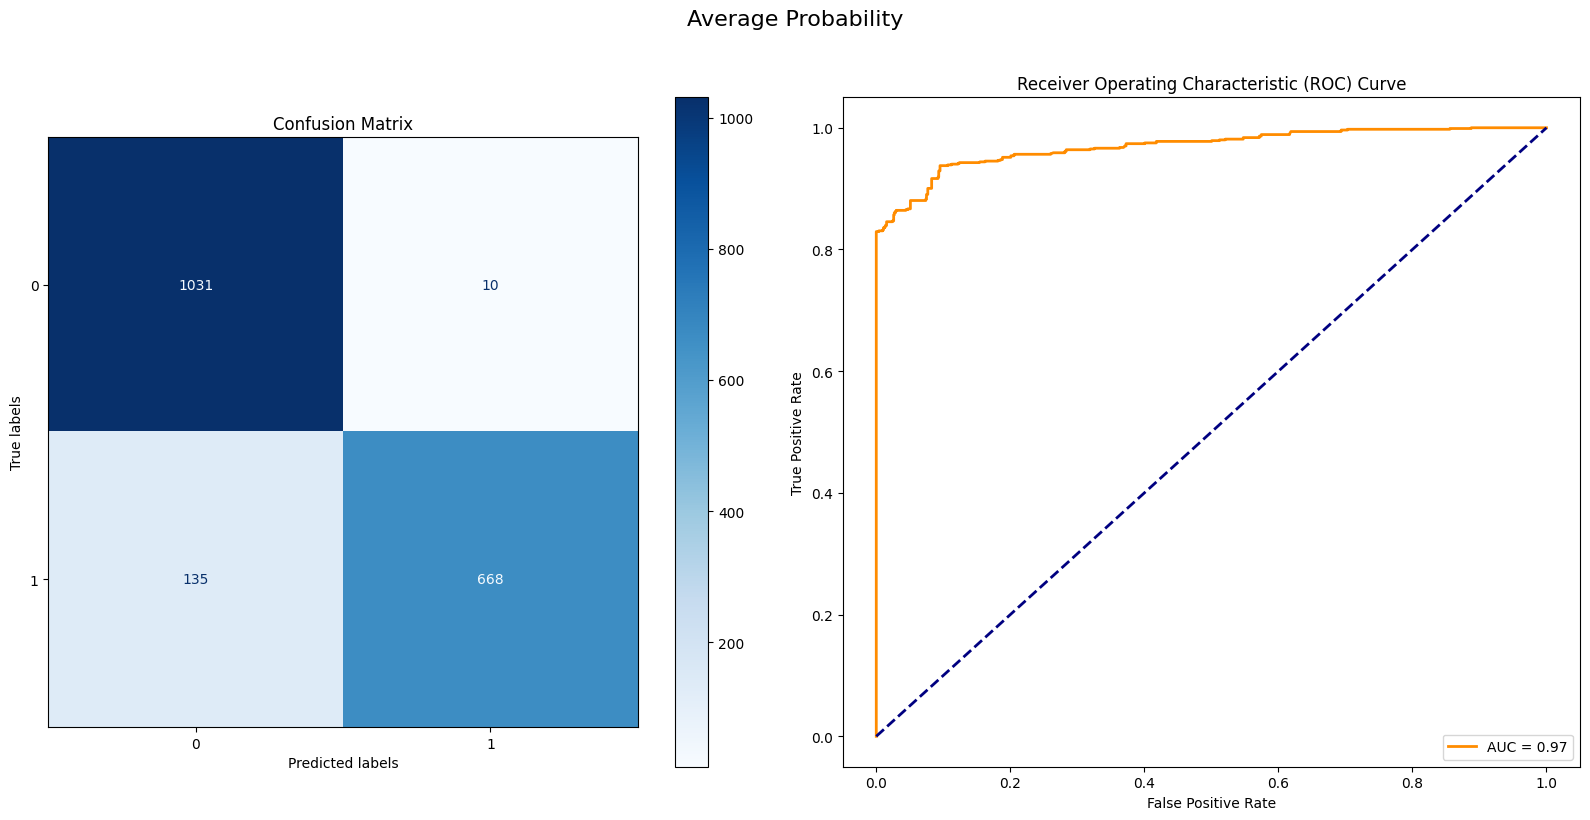

In [62]:

# avg_labels, avg_probabilities
accuracy, cm, f1, fpr, tpr, thresholds, roc_auc = calc_metrics(y_test,orig_preds['y_pred'])
plot_metrics(cm, fpr, tpr, roc_auc, thresholds, title = 'Average Probability')
# accuracy, f1, thresholds

In [26]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import FeatureUnion, Pipeline
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import pandas as pd
# import numpy as np

# # Custom transformer 1
# class CustomTransformer1(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         # Custom transformation logic
#         return X * 2

# # Custom transformer 2
# class CustomTransformer2(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         # Custom transformation logic
#         return np.log1p(X)

# # Sample DataFrame
# data = {'feature1': [1, 2, 3, 4, 5],
#         'feature2': [10, 20, 30, 40, 50]}
# df = pd.DataFrame(data)

# # Create a pipeline for each transformer
# pipeline1 = Pipeline([
#     ('scaler1', StandardScaler()),
#     ('custom1', CustomTransformer1())
# ])

# pipeline2 = Pipeline([
#     ('scaler2', MinMaxScaler()),
#     ('custom2', CustomTransformer2())
# ])

# # Combine the pipelines side by side
# combined_features = FeatureUnion([
#     ('pipeline1', pipeline1),
#     ('pipeline2', pipeline2)
# ])

# # Apply the combined transformer to your data
# transformed_data = combined_features.fit_transform(df)
# print(transformed_data)


In [27]:
# transformed_data.shape

In [28]:
# combined_features

In [29]:
# pipeline1.transform(df).shape

In [30]:
# pipeline2.transform(df).shape